# Live Object Detection with OpenVINO™

This notebook demonstrates live object detection with OpenVINO, using the [SSDLite MobileNetV2](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/ssdlite_mobilenet_v2) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). Final part of this notebook shows live inference results from a webcam. Additionally, you can also upload a video file.

> **NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server, the webcam will not work. However, you can still do inference on a video.

## Preparation

### Install requirements

In [2]:
!pip install -q "openvino-dev>=2023.0.0"
!pip install -q tensorflow
!pip install -q opencv-python requests tqdm

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

('notebook_utils.py', <http.client.HTTPMessage at 0x2426edfdfa0>)

### Imports

In [3]:
import collections
import tarfile
import time
from pathlib import Path

import cv2
import numpy as np
from IPython import display
from openvino import runtime as ov
from openvino.tools.mo.front import tf as ov_tf_front
from openvino.tools import mo

import notebook_utils as utils

## The Model

### Download the Model

Use the `download_file`, a function from the `notebook_utils` file. It automatically creates a directory structure and downloads the selected model. This step is skipped if the package is already downloaded and unpacked. The chosen model comes from the public directory, which means it must be converted into OpenVINO Intermediate Representation (OpenVINO IR).

> **NOTE**: Using a model other than `ssdlite_mobilenet_v2` may require different conversion parameters as well as pre- and post-processing.

In [4]:
# A directory where the model will be downloaded.
base_model_dir = Path("model")

# The name of the model from Open Model Zoo
model_name = "ssdlite_mobilenet_v2"

archive_name = Path(f"{model_name}_coco_2018_05_09.tar.gz")
model_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/public/2022.1/{model_name}/{archive_name}"

# Download the archive
downloaded_model_path = base_model_dir / archive_name
if not downloaded_model_path.exists():
    utils.download_file(model_url, downloaded_model_path.name, downloaded_model_path.parent)

# Unpack the model
tf_model_path = base_model_dir / archive_name.with_suffix("").stem / "frozen_inference_graph.pb"
if not tf_model_path.exists():
    with tarfile.open(downloaded_model_path) as file:
        file.extractall(base_model_dir)

model\ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz:   0%|          | 0.00/48.7M [00:00<?, ?B/s]

### Convert the Model

The pre-trained model is in TensorFlow format. To use it with OpenVINO, convert it to OpenVINO IR format using [Model Optimizer Python API](https://docs.openvino.ai/2022.3/openvino_docs_MO_DG_Python_API.html) (`mo.convert_model` function). If the model has been already converted, this step is skipped.

In [5]:
precision = "FP16"
# The output path for the conversion.
converted_model_path = Path("model") / f"{model_name}_{precision.lower()}.xml"

# Convert it to IR if not previously converted
trans_config_path = Path(ov_tf_front.__file__).parent / "ssd_v2_support.json"
if not converted_model_path.exists():
    ov_model = mo.convert_model(
        tf_model_path, 
        compress_to_fp16=(precision == 'FP16'), 
        transformations_config=trans_config_path,
        tensorflow_object_detection_api_pipeline_config=tf_model_path.parent / "pipeline.config", 
        reverse_input_channels=True
    )
    ov.serialize(ov_model, converted_model_path)
    del ov_model

[ WARNING ]  The Preprocessor block has been removed. Only nodes performing mean value subtraction and scaling (if applicable) are kept.


### Load the Model

Only a few lines of code are required to run the model. First, initialize OpenVINO Runtime. Then, read the network architecture and model weights from the `.bin` and `.xml` files to compile for the desired device. If you choose `GPU` you need to wait for a while, as the startup time is much longer than in the case of `CPU`.

There is a possibility to let OpenVINO decide which hardware offers the best performance. For that purpose, just use `AUTO`. Remember that for most cases the best hardware is `GPU` (better performance, but longer startup time).

In [6]:
# Initialize OpenVINO Runtime.
ie_core = ov.Core()
# Read the network and corresponding weights from a file.
model = ie_core.read_model(model=converted_model_path)
# Compile the model for CPU (you can choose manually CPU, GPU etc.)
# or let the engine choose the best available device (AUTO).
compiled_model = ie_core.compile_model(model=model, device_name="CPU")

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

# Get the input size.
height, width = list(input_layer.shape)[1:3]

Input and output layers have the names of the input node and output node respectively. In the case of SSDLite MobileNetV2, there is 1 input and 1 output.

In [7]:
input_layer.any_name, output_layer.any_name

('image_tensor:0', 'detection_boxes:0')

## Processing

### Process Results

First, list all available classes and create colors for them. Then, in the post-process stage, transform boxes with normalized coordinates `[0, 1]` into boxes with pixel coordinates `[0, image_size_in_px]`. Afterward, use [non-maximum suppression](https://paperswithcode.com/method/non-maximum-suppression) to reject overlapping detections and those below the probability threshold (0.5). Finally, draw boxes and labels inside them.

In [8]:
# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
classes = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant",
    "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe", "eye glasses",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "mirror", "dining table", "window", "desk", "toilet",
    "door", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors",
    "teddy bear", "hair drier", "toothbrush", "hair brush"
]

# Colors for the classes above (Rainbow Color Map).
colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(classes), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()


def process_results(frame, results, thresh=0.6):
    # The size of the original frame.
    h, w = frame.shape[:2]
    # The 'results' variable is a [1, 1, 100, 7] tensor.
    results = results.squeeze()
    boxes = []
    labels = []
    scores = []
    for _, label, score, xmin, ymin, xmax, ymax in results:
        # Create a box with pixels coordinates from the box with normalized coordinates [0,1].
        boxes.append(
            tuple(map(int, (xmin * w, ymin * h, (xmax - xmin) * w, (ymax - ymin) * h)))
        )
        labels.append(int(label))
        scores.append(float(score))

    # Apply non-maximum suppression to get rid of many overlapping entities.
    # See https://paperswithcode.com/method/non-maximum-suppression
    # This algorithm returns indices of objects to keep.
    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes, scores=scores, score_threshold=thresh, nms_threshold=0.6
    )

    # If there are no boxes.
    if len(indices) == 0:
        return []

    # Filter detected objects.
    return [(labels[idx], scores[idx], boxes[idx]) for idx in indices.flatten()]


def draw_boxes(frame, boxes):
    for label, score, box in boxes:
        # Choose color for the label.
        color = tuple(map(int, colors[label]))
        # Draw a box.
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]
        cv2.rectangle(img=frame, pt1=box[:2], pt2=(x2, y2), color=color, thickness=3)

        # Draw a label name inside the box.
        cv2.putText(
            img=frame,
            text=f"{classes[label]} {score:.2f}",
            org=(box[0] + 10, box[1] + 30),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=frame.shape[1] / 1000,
            color=color,
            thickness=1,
            lineType=cv2.LINE_AA,
        )

    return frame

### Main Processing Function

Run object detection on the specified source. Either a webcam or a video file.

In [9]:
# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Resize the image and change dims to fit neural network input.
            input_img = cv2.resize(
                src=frame, dsize=(width, height), interpolation=cv2.INTER_AREA
            )
            # Create a batch of images (size = 1).
            input_img = input_img[np.newaxis, ...]

            # Measure processing time.

            start_time = time.time()
            # Get the results.
            results = compiled_model([input_img])[output_layer]
            stop_time = time.time()
            # Get poses from network results.
            boxes = process_results(frame=frame, results=results)

            # Draw boxes on a frame.
            frame = draw_boxes(frame=frame, boxes=boxes)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

## Run

### Run Live Object Detection

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

> **NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server (for example, Binder), the webcam will not work. Popup mode may not work if you run this notebook on a remote computer (for example, Binder).

Run the object detection:

In [10]:
run_object_detection(source=0, flip=True, use_popup=False)

Interrupted


### Run Object Detection on a Video File

If you do not have a webcam, you can still run this demo with a video file. Any [format supported by OpenCV](https://docs.opencv.org/4.5.1/dd/d43/tutorial_py_video_display.html) will work.

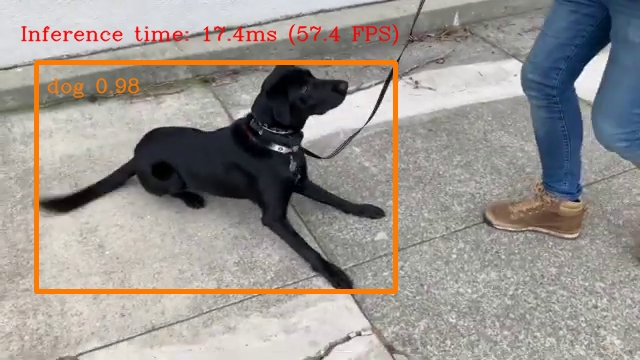

Source ended


In [14]:
video_file = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4"

run_object_detection(source=video_file, flip=False, use_popup=False)

## References

1. [SSDLite MobileNetV2](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/ssdlite_mobilenet_v2)
2. [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/)
3. [Non-Maximum Suppression](https://paperswithcode.com/method/non-maximum-suppression)